# Table of contents

- Introduction.

- Data Processing.

- Data exploration.

- Bag of Word.

- TF-IDF.

- Word2Vec.

- LSTM.

- LDA.
  - Bag of Word.
  - TF-IDF.

- Clustering.

- Conclusion.

## Introduction.

NLTK includes a small selection of texts from the Project Gutenberg electronic text archive, which contains some 25,000 free electronic books.

Using Bag of Word, TF-IDF, Word2Vec, LSTM apply supervised models such as Naive
Bayes, Logistic Regression, Decision Tree, Random Forest,
KNN, SVM and Gradient Boosting, including GridSearchCV.

## Data Processing.

In [0]:
import re

import nltk
from nltk.corpus import stopwords 
from nltk.corpus import gutenberg as gt
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import gensim
from gensim.models import Word2Vec

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import numpy as np

In [70]:
nltk.download('gutenberg')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
documents = gt.fileids()

Loại bỏ tên tác giả ở đầu mỗi documents và tách thành từng câu.

In [0]:
X_raw = []
y_raw = []
for doc in documents:
  txt = gt.raw(doc)
  txt = txt[txt.find('\n'):] # Loại bỏ tên tác giả.
  tokenized_text=sent_tokenize(txt) # Tách thành từng câu.
  X_raw.append(tokenized_text)
  y_raw.append(doc.split("-")[0])

In [73]:
print('Số lượng documents: ', len(documents))
print('Số lượng tác giả: ', len(set(y_raw)))
print(documents)

Số lượng documents:  18
Số lượng tác giả:  12
['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


Có 18 documents và 12 tác giả.

### Đếm số lượng từ của mỗi tác giả.

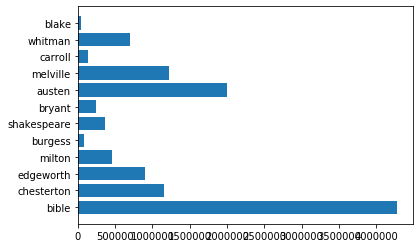

In [74]:
dict_by_authors = {}
name_authors = set(y_raw)
for author in name_authors:
  dict_by_authors[author] = 0

for content, author in zip(X_raw, y_raw):
  lengthh = 0
  for cont in content:
    lengthh += len(cont)
  dict_by_authors[author] += lengthh

fig, ax = plt.subplots() 
width = 0.75
ind = np.arange(len(dict_by_authors.values()))
ax.barh(ind, dict_by_authors.values())
ax.set_yticks(ind)
ax.set_yticklabels(dict_by_authors.keys(), minor=False)
plt.show()

Số lượng từ của blake, burgess và carroll nhỏ hơn rất nhiều so với các tác giả còn lại.

---> Loại bỏ 3 tác giả này.

In [0]:
author_remove = ['blake', 'burgess', 'carroll']

X_train = []
y_train = []

for x, y in zip(X_raw, y_raw):
  if y not in author_remove:
    X_train.append(x)
    y_train.append(y)

### Clean data.

Clean data, tách mỗi sample thành từng đoạn khoảng 1000 words.

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [0]:
X_para = []
y_para = []
doc_train = []

for contents, author in zip(X_train, y_train):
  for content in contents:
    doc_train.append(content)
    if(len(' '.join(doc_train)) > 1000):
      clean_txt = clean_text(' '.join(doc_train))
      X_para.append(clean_txt)
      y_para.append(author)
      doc_train = []

In [78]:
print(len(X_para))
print(len(y_para))

10212
10212


Dữ liệu chứa 10212 sample.

### Các từ có tần xuất xuất hiện lớn trong từng tác phẩm.

In [0]:
X_visual = []
y_author = []
for doc in documents:
  txt = gt.raw(doc)
  txt = txt[txt.find('\n'):] # Loại bỏ tên tác giả.
  txt = clean_text(txt)
  X_visual.append(txt)
  y_author.append(doc.split("-")[1][:-4])

In [80]:
print(len(X_visual))
print(len(y_author))

18
18


In [0]:
X_word2vec = []

for x in X_visual:
  tokenized_word=word_tokenize(x)
  X_word2vec.append(tokenized_word)

In [0]:
fdist = FreqDist(X_word2vec[0])

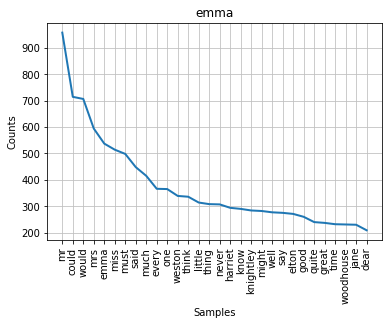

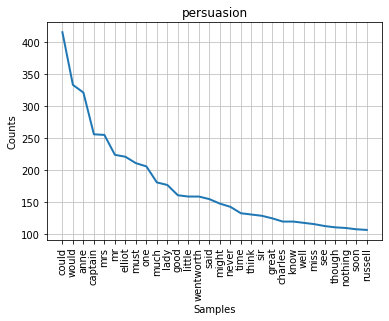

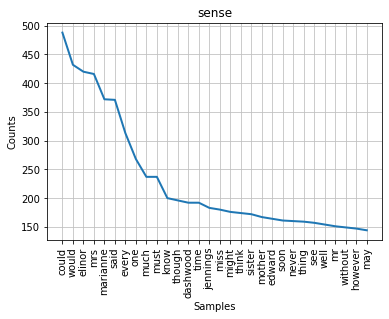

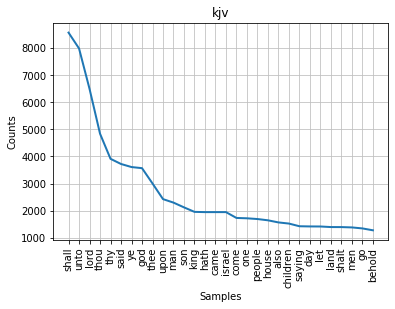

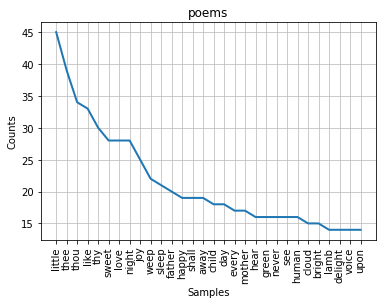

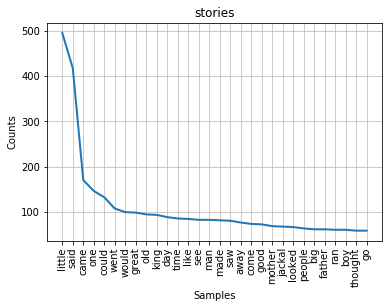

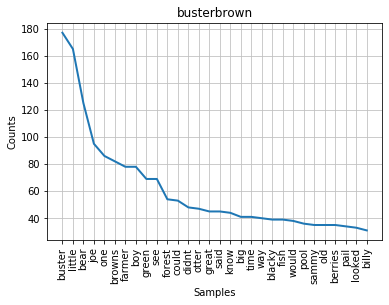

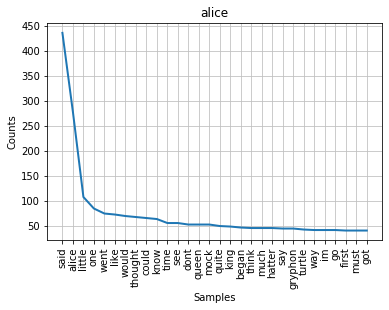

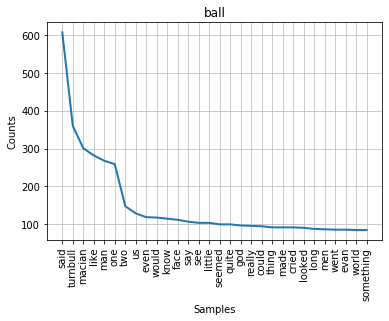

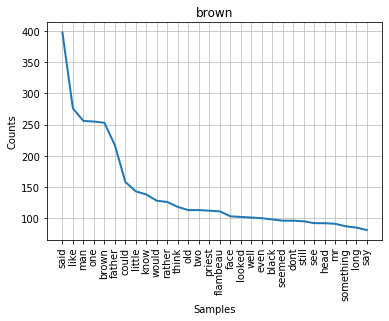

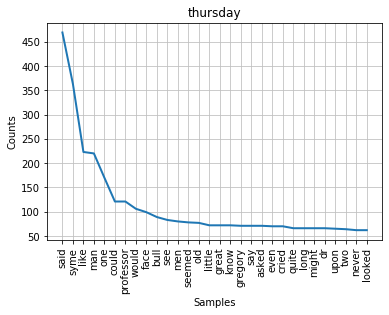

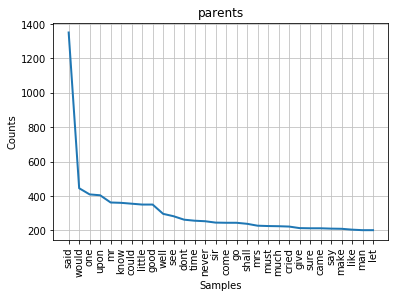

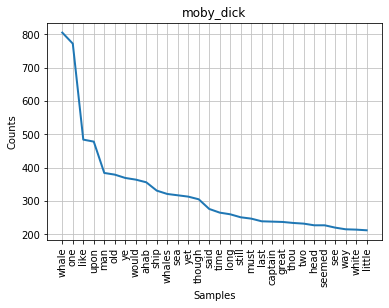

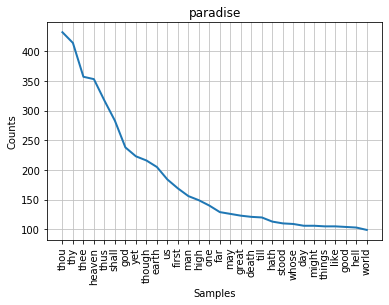

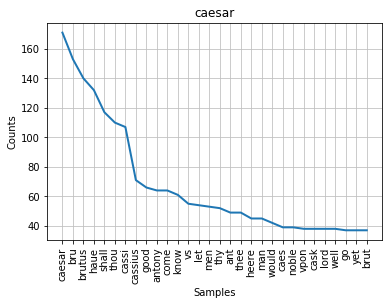

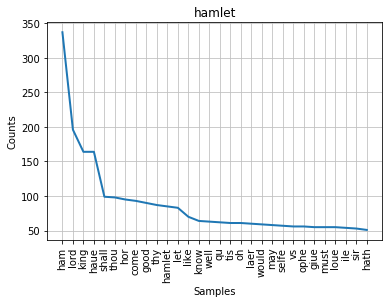

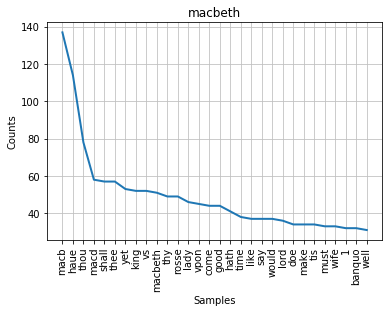

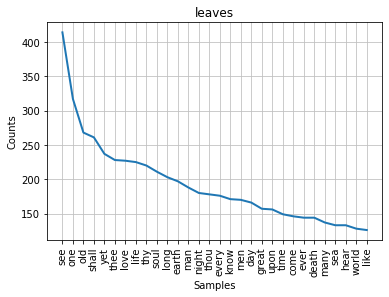

In [83]:
for w2v, author in zip(X_word2vec, y_author):
  plt.title(author)
  fdist = FreqDist(w2v)
  fdist.plot(30,cumulative=False)
  plt.show()

## Bag of Word.

In [84]:
vectorizer = CountVectorizer(min_df=10)

X_bow =  vectorizer.fit_transform(X_para)

print(X_bow.shape)

(10212, 10314)


Dữ liệu có size (10212, 113994)

In [0]:
X_tr, X_test, y_tr, y_test = train_test_split( X_bow, y_para, test_size=0.2)

### Naive Bayes.

In [0]:
gnb = GaussianNB()

model = gnb.fit(X_tr.toarray(), y_tr)

y_predict = model.predict(X_test.toarray())
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

      austen       0.99      0.99      0.99       352
       bible       1.00      0.99      1.00       768
      bryant       0.69      1.00      0.82        38
  chesterton       0.98      0.96      0.97       225
   edgeworth       0.95      0.98      0.96       161
    melville       1.00      0.92      0.96       253
      milton       0.96      0.99      0.97        71
 shakespeare       0.97      1.00      0.98        65
     whitman       0.97      0.98      0.98       110

    accuracy                           0.98      2043
   macro avg       0.95      0.98      0.96      2043
weighted avg       0.98      0.98      0.98      2043



Naive Bayes cho kết quả phân loại khá tốt trên 95%.

### Logistic Regression.

In [0]:
lrg = LogisticRegression()

model = lrg.fit(X_tr.toarray(), y_tr)

y_predict = model.predict(X_test.toarray())
print(classification_report(y_predict, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

      austen       0.98      0.98      0.98       352
       bible       1.00      0.99      1.00       768
      bryant       0.80      1.00      0.89        44
  chesterton       0.99      0.98      0.99       223
   edgeworth       0.98      0.97      0.98       167
    melville       0.98      0.97      0.97       239
      milton       0.97      0.97      0.97        73
 shakespeare       0.97      1.00      0.98        65
     whitman       0.98      0.97      0.98       112

    accuracy                           0.98      2043
   macro avg       0.96      0.98      0.97      2043
weighted avg       0.98      0.98      0.98      2043



Logistic Regression cũng cho kết quả khá tốt, trên 96%.

### Decision Tree.

In [0]:
decision_tree = DecisionTreeClassifier()

model = decision_tree.fit(X_tr.toarray(), y_tr)

y_predict = model.predict(X_test.toarray())
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

      austen       0.88      0.88      0.88       352
       bible       0.95      0.95      0.95       766
      bryant       0.35      0.56      0.43        34
  chesterton       0.76      0.73      0.74       228
   edgeworth       0.69      0.64      0.66       178
    melville       0.79      0.73      0.76       254
      milton       0.58      0.71      0.64        59
 shakespeare       0.82      0.87      0.85        63
     whitman       0.55      0.56      0.55       109

    accuracy                           0.82      2043
   macro avg       0.71      0.74      0.72      2043
weighted avg       0.83      0.82      0.82      2043



Decision Tree cho kết quả không tốt bằng Naive Bayes và Logistic Regression.

In [0]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, accuracy_score

In [0]:
# decision_tree = DecisionTreeClassifier()

# parameters = {'max_features': ['log2', 'sqrt','auto'], 
#               'criterion': ['entropy', 'gini'],
#               'max_depth': [ 10, 20, 30], 
#               'min_samples_split': [ 2, 3, 5,],
#               'min_samples_leaf': [8, 10, 12,]
#              }
# acc_scorer = make_scorer(accuracy_score)

# grid_obj = GridSearchCV(decision_tree, parameters, scoring=acc_scorer)
# grid_obj = grid_obj.fit(X_tr.toarray(), y_tr)

# decision_tree = grid_obj.best_estimator_

# decision_tree.fit(X_tr.toarray(), y_tr)

In [0]:
# y_pred = decision_tree.predict(X_test.toarray())
# print(classification_report(y_pred, y_test))

### Random Forest.

In [0]:
random_forest = RandomForestClassifier()

model = random_forest.fit(X_tr.toarray(), y_tr)

y_predict = model.predict(X_test.toarray())
print(classification_report(y_predict, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

      austen       0.98      0.67      0.80       515
       bible       1.00      0.81      0.90       936
      bryant       0.13      0.88      0.22         8
  chesterton       0.64      0.78      0.71       181
   edgeworth       0.48      0.76      0.59       104
    melville       0.72      0.87      0.79       196
      milton       0.27      0.95      0.43        21
 shakespeare       0.70      0.98      0.82        48
     whitman       0.29      0.94      0.44        34

    accuracy                           0.79      2043
   macro avg       0.58      0.85      0.63      2043
weighted avg       0.88      0.79      0.81      2043



Random Forest cũng đạt kết quả không tốt bằng Naive Bayes và Logistic Regression.

## TF-IDF

In [0]:
vectorizer = TfidfVectorizer()

X_tf_idf = vectorizer.fit_transform(X_para)

print(X_tf_idf.shape)

(10212, 113994)


Dữ liệu có size (10212, 113994)

In [0]:
X_tr, X_test, y_tr, y_test = train_test_split( X_tf_idf, y_para, test_size=0.2)

### Naive Bayes.

In [0]:
model = gnb.fit(X_tr.toarray(), y_tr)

y_predict = model.predict(X_test.toarray())
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

      austen       0.99      0.99      0.99       356
       bible       1.00      0.99      0.99       768
      bryant       0.46      1.00      0.63        29
  chesterton       0.97      0.90      0.93       238
   edgeworth       0.94      0.97      0.96       155
    melville       0.97      0.88      0.92       237
      milton       0.96      0.99      0.97        77
 shakespeare       0.98      1.00      0.99        62
     whitman       0.94      0.95      0.95       121

    accuracy                           0.96      2043
   macro avg       0.91      0.96      0.93      2043
weighted avg       0.97      0.96      0.97      2043



khi sử dụng Naive Bayes, tf-idf cho kết quả kém hơn 1 chút so với Bag of Word.

### Logistic Regession.

In [0]:
model = lrg.fit(X_tr.toarray(), y_tr)

y_predict = model.predict(X_test.toarray())
print(classification_report(y_predict, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

      austen       1.00      0.95      0.98       375
       bible       1.00      0.98      0.99       779
      bryant       0.38      1.00      0.55        24
  chesterton       0.98      0.90      0.94       242
   edgeworth       0.89      0.98      0.93       146
    melville       0.99      0.96      0.97       224
      milton       0.90      0.99      0.94        72
 shakespeare       0.98      1.00      0.99        62
     whitman       0.96      0.98      0.97       119

    accuracy                           0.96      2043
   macro avg       0.90      0.97      0.92      2043
weighted avg       0.98      0.96      0.97      2043



Logistic Regression cùng với TF-IDF cũng cho kết quả khá cao nhưng cũng thấp hơn Bag of Word.

### Decision Tree.

In [0]:
model = decision_tree.fit(X_tr.toarray(), y_tr)

y_predict = model.predict(X_test.toarray())
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

      austen       0.89      0.87      0.88       369
       bible       0.96      0.95      0.95       769
      bryant       0.27      0.52      0.35        33
  chesterton       0.69      0.74      0.72       207
   edgeworth       0.71      0.60      0.65       191
    melville       0.78      0.73      0.76       229
      milton       0.61      0.74      0.67        65
 shakespeare       0.87      0.96      0.92        57
     whitman       0.58      0.58      0.58       123

    accuracy                           0.82      2043
   macro avg       0.71      0.74      0.72      2043
weighted avg       0.83      0.82      0.82      2043



Decision Tree cho kết quả tương đương khi sử dụng Bag of Word.

### Random Forest.

In [0]:
model = random_forest.fit(X_tr.toarray(), y_tr)

y_predict = model.predict(X_test.toarray())
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

      austen       0.97      0.74      0.84       472
       bible       1.00      0.80      0.89       945
      bryant       0.06      0.80      0.12         5
  chesterton       0.65      0.76      0.70       192
   edgeworth       0.46      0.72      0.56       101
    melville       0.74      0.80      0.77       199
      milton       0.29      1.00      0.45        23
 shakespeare       0.89      1.00      0.94        56
     whitman       0.33      0.80      0.47        50

    accuracy                           0.79      2043
   macro avg       0.60      0.82      0.64      2043
weighted avg       0.88      0.79      0.82      2043



Random Forest cũng cho kết quả tương đương khi sử dụng Bag of Word.

## Word2Vec.

In [0]:
X_word2vec = []

for x in X_para:
  tokenized_word=word_tokenize(x)
  X_word2vec.append(tokenized_word)

In [0]:
model = Word2Vec(X_word2vec, min_count=1, size= 300, workers=3, window =5, sg = 1)

In [0]:
def sent_vectorizer(sent, model):
    sent_vec = np.zeros(300)
    numw = 0
    for w in sent:
      sent_vec = np.add(sent_vec, model[w])
      numw+=1
    return sent_vec/numw

Chuyển đoạn văn sang vector bằng cách lấy trung bình cộng của các từ.

In [0]:
X_data = []
for sent in X_word2vec:
  X_data.append(sent_vectorizer(sent, model))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [0]:
X_data = np.array(X_data)
X_data.shape

(10212, 300)

Dữ liệu có size (10212, 300).

In [0]:
X_tr, X_test, y_tr, y_test = train_test_split( X_data, y_para, test_size=0.2)

### Naive Bayes.

In [0]:
model = gnb.fit(X_tr, y_tr)

y_predict = model.predict(X_test)
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

      austen       0.90      0.95      0.92       355
       bible       0.96      0.99      0.97       716
      bryant       0.47      0.51      0.49        45
  chesterton       0.64      0.73      0.68       210
   edgeworth       0.67      0.64      0.66       188
    melville       0.75      0.69      0.72       235
      milton       0.72      0.57      0.64       101
 shakespeare       0.97      0.97      0.97        65
     whitman       0.70      0.59      0.64       128

    accuracy                           0.83      2043
   macro avg       0.75      0.74      0.74      2043
weighted avg       0.83      0.83      0.83      2043



### Logistic Regression.

In [0]:
model = lrg.fit(X_tr, y_tr)

y_predict = model.predict(X_test)
print(classification_report(y_predict, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

      austen       0.99      0.87      0.93       421
       bible       1.00      0.96      0.98       761
      bryant       0.31      1.00      0.47        15
  chesterton       0.79      0.82      0.80       231
   edgeworth       0.64      0.84      0.73       138
    melville       0.87      0.74      0.80       252
      milton       0.70      0.92      0.80        62
 shakespeare       1.00      0.96      0.98        68
     whitman       0.73      0.83      0.78        95

    accuracy                           0.88      2043
   macro avg       0.78      0.88      0.81      2043
weighted avg       0.91      0.88      0.89      2043



### Decision Tree.

In [0]:
model = decision_tree.fit(X_tr, y_tr)

y_predict = model.predict(X_test)
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

      austen       0.90      0.88      0.89       380
       bible       0.98      0.98      0.98       732
      bryant       0.39      0.47      0.43        40
  chesterton       0.70      0.73      0.72       230
   edgeworth       0.55      0.55      0.55       179
    melville       0.70      0.70      0.70       215
      milton       0.75      0.79      0.77        77
 shakespeare       0.95      0.94      0.95        66
     whitman       0.73      0.64      0.68       124

    accuracy                           0.83      2043
   macro avg       0.74      0.74      0.74      2043
weighted avg       0.83      0.83      0.83      2043



### Random Forest.

In [0]:
model = random_forest.fit(X_tr, y_tr)

y_predict = model.predict(X_test)
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

      austen       0.96      0.90      0.93       395
       bible       1.00      0.98      0.99       747
      bryant       0.41      0.65      0.50        31
  chesterton       0.75      0.79      0.77       227
   edgeworth       0.66      0.77      0.71       155
    melville       0.86      0.78      0.82       236
      milton       0.81      0.78      0.80        85
 shakespeare       1.00      0.97      0.98        67
     whitman       0.70      0.76      0.73       100

    accuracy                           0.88      2043
   macro avg       0.80      0.82      0.80      2043
weighted avg       0.89      0.88      0.88      2043



Naive Bayes và Logistic Regression cho kết quả không tốt bằng Bag of Word và  TF-IDF.

Decision Tree và Random Forest cho kết quả tương đương với Bag of Word và TF-IDF.

Nhận xét:
- Word2Vec biểu diễn tốt đối với từng từ đơn lẻ nhưng khi biểu diễn cả một đoạn văn hơn 1000 từ bằng cách lấy trung bình cộng của các từ trong đoạn văn nên đã dẫn đến sai lệch khi biểu diễn. Tuy vậy kết quả phân loại vẫn đạt trên 80%.
- Word2Vec sẽ cho kết quả tốt hơn khi sử dụng đê biểu diễn một câu hoặc một đoạn có số từ nhỏ. 

## LSTM

In [0]:
MAX_NB_WORDS = 10300
MAX_SEQUENCE_LENGTH = 900
EMBEDDING_DIM = 300

In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_para)
# word_index = tokenizer.word_index

In [0]:
X = tokenizer.texts_to_sequences(X_para)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y_para)

y_onehot = to_categorical(y_encoded)

In [0]:
X_tr, X_test, y_tr, y_test = train_test_split( X, y_onehot, test_size=0.2)

In [0]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
epochs = 15
batch_size = 128

history = model.fit(X_tr, y_tr, epochs=epochs, 
                    batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 7352 samples, validate on 817 samples
Epoch 1/15





7352/7352 [==============================] - 133s 18ms/step - loss: 1.5782 - acc: 0.4709 - val_loss: 0.9670 - val_acc: 0.6499
Epoch 2/15
7352/7352 [==============================] - 122s 17ms/step - loss: 0.8434 - acc: 0.7043 - val_loss: 0.6985 - val_acc: 0.7356
Epoch 3/15
7352/7352 [==============================] - 123s 17ms/step - loss: 0.5693 - acc: 0.8304 - val_loss: 0.4299 - val_acc: 0.8592
Epoch 4/15
7352/7352 [==============================] - 121s 16ms/step - loss: 0.3014 - acc: 0.9128 - val_loss: 0.2905 - val_acc: 0.9119
Epoch 5/15
7352/7352 [==============================] - 125s 17ms/step - loss: 0.1870 - acc: 0.9493 - val_loss: 0.2218 - val_acc: 0.9364
Epoch 6/15
7352/7352 [==============================] - 128s 17ms/step - loss: 0.1105 - acc: 0.9709 - val_loss: 0.1947 - val_acc: 0.9412
Epoch 7/15
7352/7352 [=======

LSTM đạt kết quả khá cao.

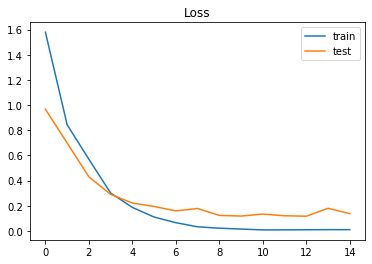

In [0]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

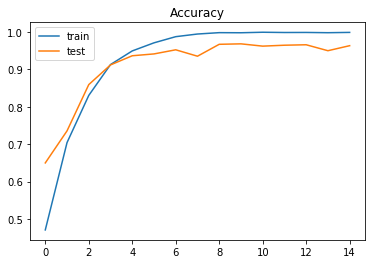

In [0]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [0]:
y_predict = model.predict(X_test)

In [0]:
predict = np.argmax(y_predict, axis=1)
y_pred = label_encoder.inverse_transform(predict)

In [0]:
y_testt = np.argmax(y_test, axis=1)
y_testt = label_encoder.inverse_transform(y_testt)

In [0]:
print(classification_report(y_pred, y_testt))

              precision    recall  f1-score   support

      austen       0.99      0.99      0.99       357
       bible       1.00      1.00      1.00       768
      bryant       0.63      0.87      0.73        38
  chesterton       0.96      0.93      0.94       221
   edgeworth       0.96      0.94      0.95       163
    melville       0.94      0.93      0.93       222
      milton       0.89      0.91      0.90        80
 shakespeare       0.92      0.98      0.95        56
     whitman       0.94      0.85      0.89       138

    accuracy                           0.96      2043
   macro avg       0.91      0.93      0.92      2043
weighted avg       0.96      0.96      0.96      2043



LSTM đạt kết quả khá cao.

## LDA

### Bag of Word

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [90]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_tr.toarray(), y_tr)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [91]:
y_predict = clf.predict(X_test.toarray())
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

      austen       0.93      0.86      0.90       366
       bible       0.98      0.97      0.98       790
      bryant       0.83      0.81      0.82        43
  chesterton       0.86      0.83      0.84       221
   edgeworth       0.83      0.85      0.84       164
    melville       0.80      0.85      0.83       230
      milton       0.84      0.96      0.90        67
 shakespeare       0.95      1.00      0.97        53
     whitman       0.78      0.86      0.82       109

    accuracy                           0.90      2043
   macro avg       0.87      0.89      0.88      2043
weighted avg       0.91      0.90      0.91      2043



In [0]:
from sklearn.decomposition import LatentDirichletAllocation

In [0]:
lda = LatentDirichletAllocation(n_components=300)
lda.fit(X_bow)
data = lda.transform(X_bow)

In [0]:
X_tr, X_test, y_tr, y_test = train_test_split( data, y_para, test_size=0.2)

#### Naive Bayes.

In [97]:
model = gnb.fit(X_tr, y_tr)

y_predict = model.predict(X_test)
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

      austen       0.65      0.84      0.74       288
       bible       0.80      0.98      0.88       657
      bryant       0.59      0.10      0.16       240
  chesterton       0.20      0.41      0.27       108
   edgeworth       0.37      0.30      0.33       184
    melville       0.25      0.50      0.34       112
      milton       0.42      0.11      0.18       207
 shakespeare       0.62      0.48      0.54       105
     whitman       0.18      0.13      0.15       142

    accuracy                           0.57      2043
   macro avg       0.45      0.43      0.40      2043
weighted avg       0.56      0.57      0.53      2043



Kết quả không tốt với Naive Bayes.

#### Logistic Regression.

In [98]:
model = lrg.fit(X_tr, y_tr)

y_predict = model.predict(X_test)
print(classification_report(y_predict, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

      austen       0.96      0.95      0.95       377
       bible       1.00      0.92      0.96       869
      bryant       0.21      0.62      0.31        13
  chesterton       0.82      0.79      0.80       227
   edgeworth       0.76      0.74      0.75       152
    melville       0.77      0.77      0.77       222
      milton       0.47      0.74      0.58        35
 shakespeare       0.96      0.97      0.97        79
     whitman       0.53      0.83      0.65        69

    accuracy                           0.87      2043
   macro avg       0.72      0.81      0.75      2043
weighted avg       0.90      0.87      0.88      2043



#### Decision Tree.

In [99]:
model = decision_tree.fit(X_tr, y_tr)

y_predict = model.predict(X_test)
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

      austen       0.92      0.93      0.93       370
       bible       0.93      0.94      0.93       795
      bryant       0.31      0.33      0.32        36
  chesterton       0.73      0.68      0.71       233
   edgeworth       0.61      0.63      0.62       142
    melville       0.79      0.78      0.78       222
      milton       0.73      0.57      0.64        70
 shakespeare       0.96      0.95      0.96        81
     whitman       0.53      0.61      0.57        94

    accuracy                           0.83      2043
   macro avg       0.72      0.71      0.72      2043
weighted avg       0.83      0.83      0.83      2043



#### Random Forest.

In [100]:
model = random_forest.fit(X_tr, y_tr)

y_predict = model.predict(X_test)
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

      austen       0.99      0.88      0.93       418
       bible       0.97      0.94      0.96       832
      bryant       0.21      0.35      0.26        23
  chesterton       0.79      0.71      0.75       244
   edgeworth       0.49      0.63      0.55       116
    melville       0.78      0.84      0.81       205
      milton       0.64      0.81      0.71        43
 shakespeare       0.99      1.00      0.99        79
     whitman       0.54      0.70      0.61        83

    accuracy                           0.86      2043
   macro avg       0.71      0.76      0.73      2043
weighted avg       0.88      0.86      0.86      2043



LDA kết hợp với Bag of Word cho kết quả không cao.

### TF-IDF

In [0]:
vectorizer = TfidfVectorizer()

X_tf_idf = vectorizer.fit_transform(X_para)

X_tr, X_test, y_tr, y_test = train_test_split( X_tf_idf, y_para, test_size=0.2)

#### Naive Bayes.

In [103]:
model = gnb.fit(X_tr.toarray(), y_tr)

y_predict = model.predict(X_test.toarray())
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

      austen       1.00      0.98      0.99       322
       bible       1.00      0.99      1.00       805
      bryant       0.65      1.00      0.78        31
  chesterton       0.97      0.93      0.95       213
   edgeworth       0.94      0.98      0.96       171
    melville       0.98      0.93      0.95       255
      milton       0.88      1.00      0.94        59
 shakespeare       1.00      1.00      1.00        74
     whitman       0.97      0.96      0.96       113

    accuracy                           0.97      2043
   macro avg       0.93      0.97      0.95      2043
weighted avg       0.98      0.97      0.98      2043



#### Logistic Regression.

In [104]:
model = lrg.fit(X_tr, y_tr)

y_predict = model.predict(X_test)
print(classification_report(y_predict, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

      austen       1.00      0.96      0.98       330
       bible       1.00      0.98      0.99       819
      bryant       0.50      1.00      0.67        24
  chesterton       0.98      0.91      0.95       221
   edgeworth       0.96      0.99      0.97       172
    melville       0.98      0.98      0.98       244
      milton       0.82      1.00      0.90        55
 shakespeare       0.96      1.00      0.98        71
     whitman       0.95      0.98      0.96       107

    accuracy                           0.97      2043
   macro avg       0.91      0.98      0.93      2043
weighted avg       0.98      0.97      0.97      2043



#### Decision Tree.

In [105]:
model = decision_tree.fit(X_tr, y_tr)

y_predict = model.predict(X_test)
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

      austen       0.89      0.80      0.84       349
       bible       0.95      0.93      0.94       813
      bryant       0.48      0.51      0.49        45
  chesterton       0.74      0.76      0.75       199
   edgeworth       0.64      0.70      0.67       162
    melville       0.78      0.79      0.78       239
      milton       0.63      0.64      0.63        66
 shakespeare       0.85      0.89      0.87        71
     whitman       0.57      0.64      0.60        99

    accuracy                           0.82      2043
   macro avg       0.72      0.74      0.73      2043
weighted avg       0.83      0.82      0.83      2043



#### Random Forest.

In [106]:
model = random_forest.fit(X_tr, y_tr)

y_predict = model.predict(X_test)
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

      austen       0.99      0.72      0.83       437
       bible       1.00      0.85      0.92       944
      bryant       0.21      0.91      0.34        11
  chesterton       0.71      0.78      0.74       188
   edgeworth       0.47      0.81      0.60       105
    melville       0.76      0.81      0.79       229
      milton       0.27      0.90      0.41        20
 shakespeare       0.86      1.00      0.93        64
     whitman       0.36      0.89      0.51        45

    accuracy                           0.81      2043
   macro avg       0.63      0.85      0.67      2043
weighted avg       0.89      0.81      0.83      2043



LDA với TF-IDF cho kết quả khá tốt với Naive Bayes và Logistic Regression, với Decision Tree và Random Forest thì kết quả kém hơn,

## Clustering

In [0]:
from sklearn.cluster import KMeans 
from scipy.spatial.distance import cdist

In [0]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
import matplotlib.cm as cm

In [0]:
range_n_clusters = [3, 4, 5, 6, 7, 8, 9, 10]

For n_clusters = 3 The average silhouette_score is : 0.07579590495265369
For n_clusters = 4 The average silhouette_score is : 0.06402907304197754
For n_clusters = 5 The average silhouette_score is : 0.0031504398643999025
For n_clusters = 6 The average silhouette_score is : 0.004728768169040734
For n_clusters = 7 The average silhouette_score is : -0.007434077058953361
For n_clusters = 8 The average silhouette_score is : -0.006305378347248094
For n_clusters = 9 The average silhouette_score is : -0.0060366440141548855
For n_clusters = 10 The average silhouette_score is : -0.00366027535625061


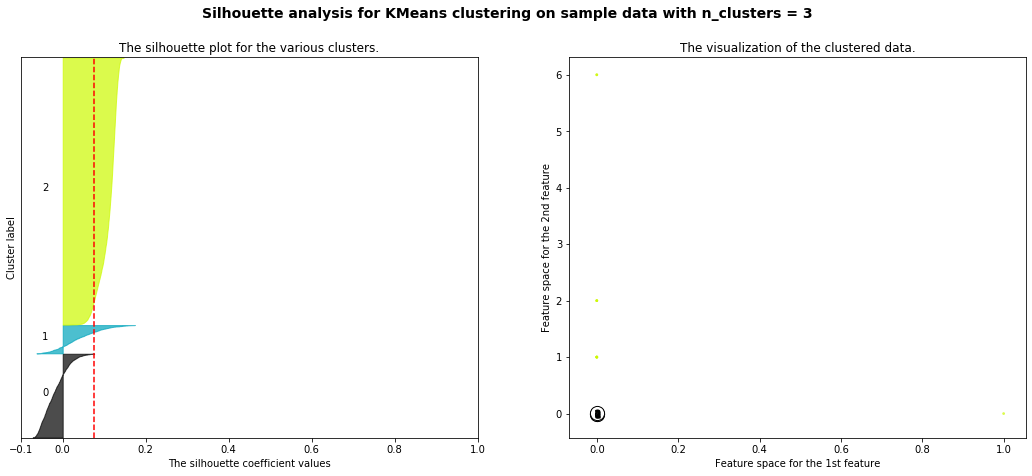

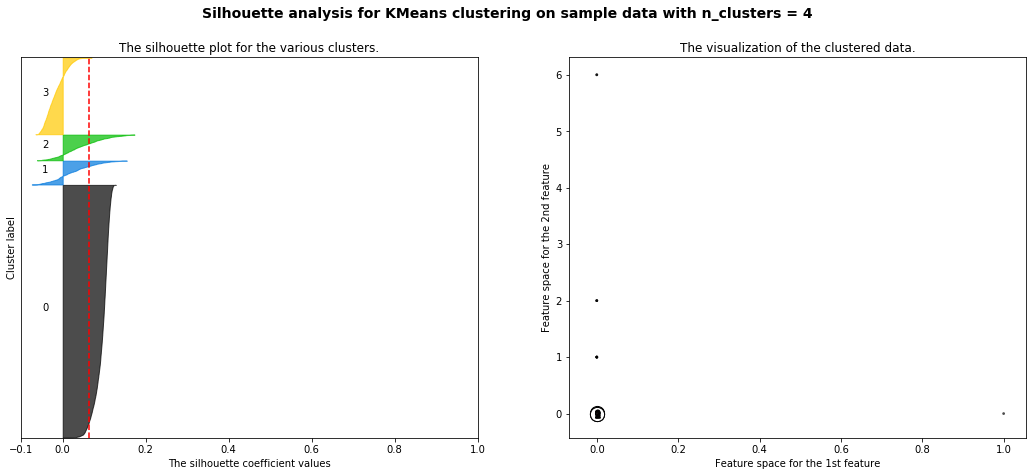

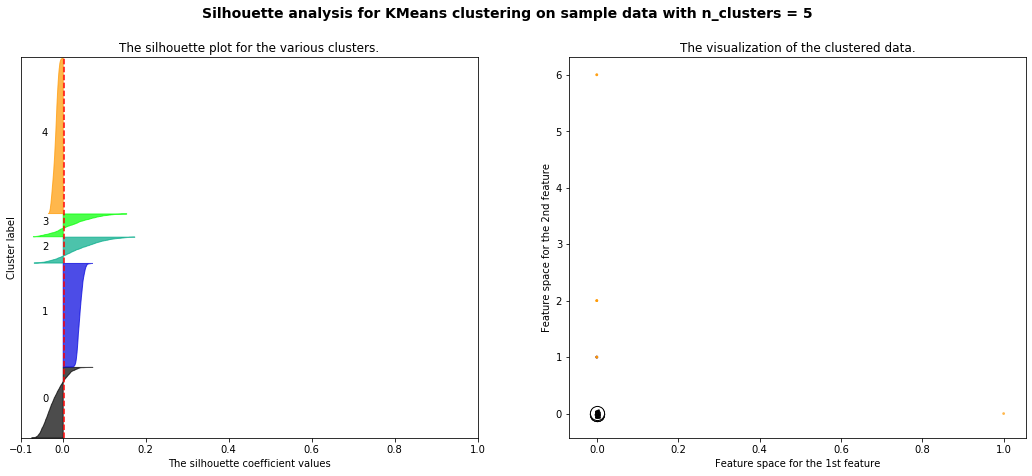

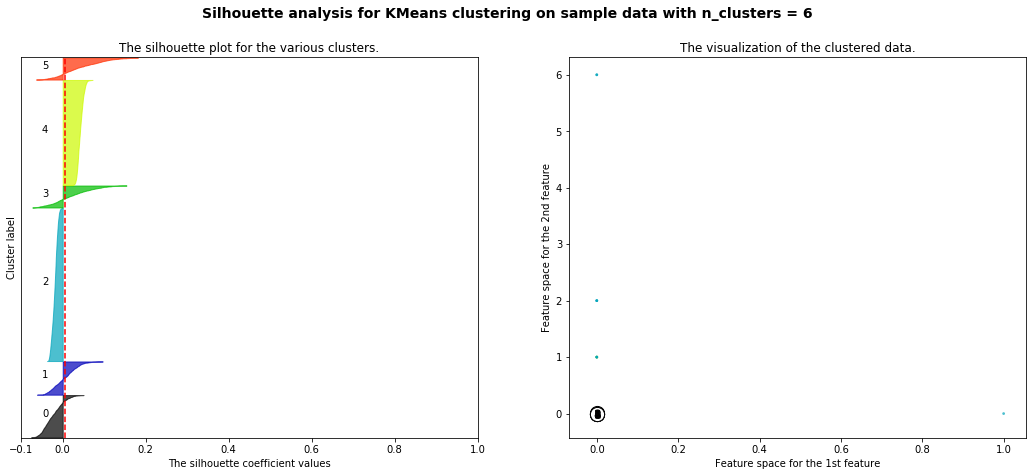

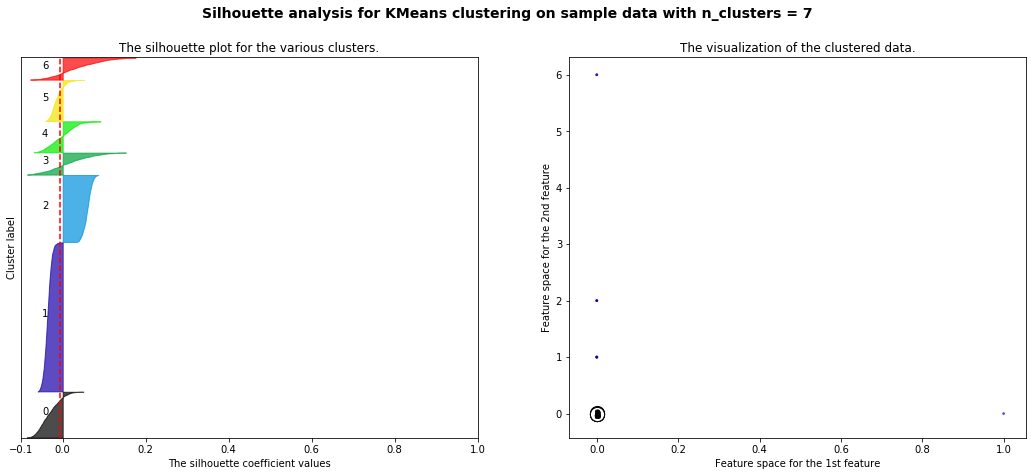

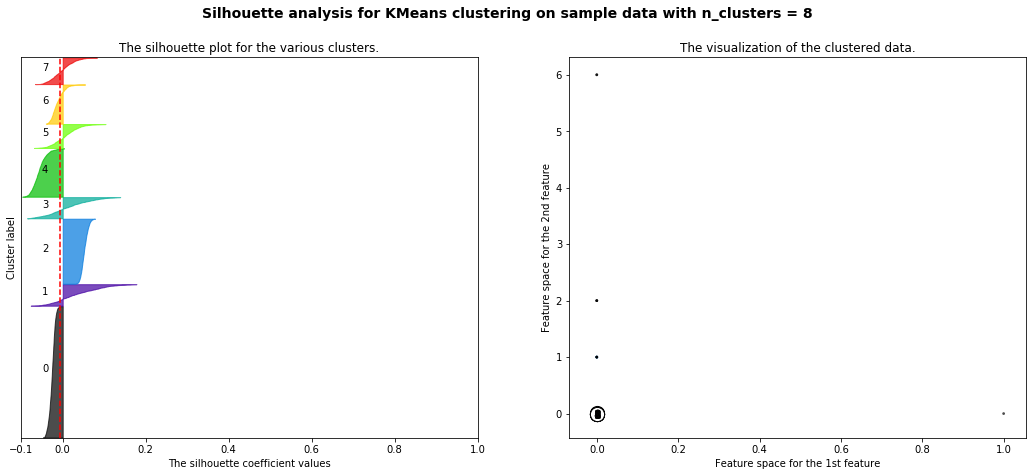

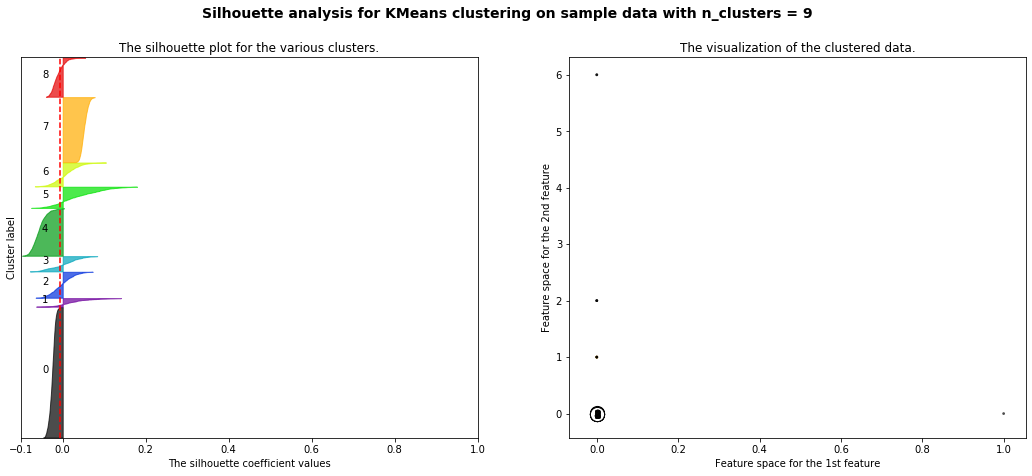

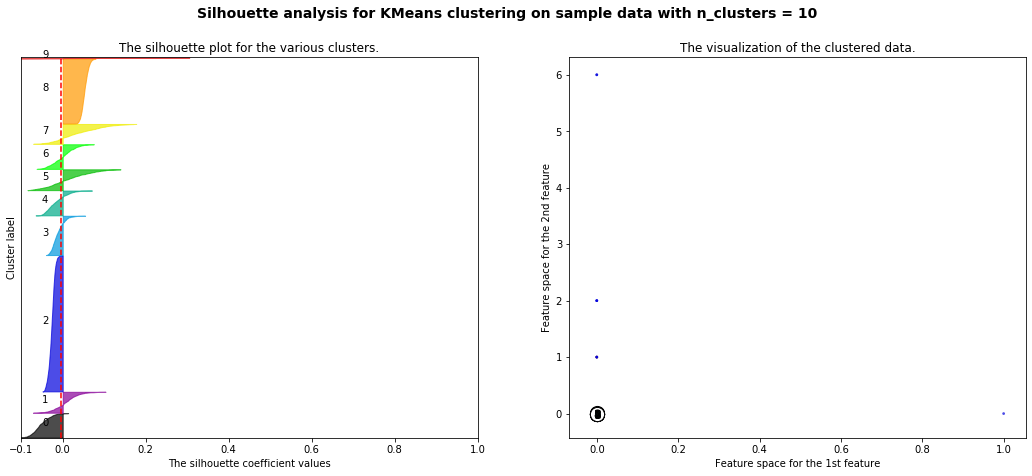

In [0]:
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X_bow.shape[0] + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_bow)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_bow, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_bow, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_bow[:, 0].toarray(), X_bow[:, 1].toarray(), marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

KMeans cho kết quả phân loại không tốt, giá trị silhouette scores rất nhỏ, thậm chí âm do các từ đều xuất hiện trong các document, rất ít từ chỉ xuất hiện trong 1 document cụ thể.

For n_clusters = 3 The average silhouette_score is : 0.003392050972791395
For n_clusters = 4 The average silhouette_score is : 0.0036027209908312116
For n_clusters = 5 The average silhouette_score is : 0.004018657317393231
For n_clusters = 6 The average silhouette_score is : 0.004647178428642647
For n_clusters = 7 The average silhouette_score is : 0.005332763987673202
For n_clusters = 8 The average silhouette_score is : 0.0054548409011070725
For n_clusters = 9 The average silhouette_score is : 0.004142461526290912
For n_clusters = 10 The average silhouette_score is : 0.004496316581743837


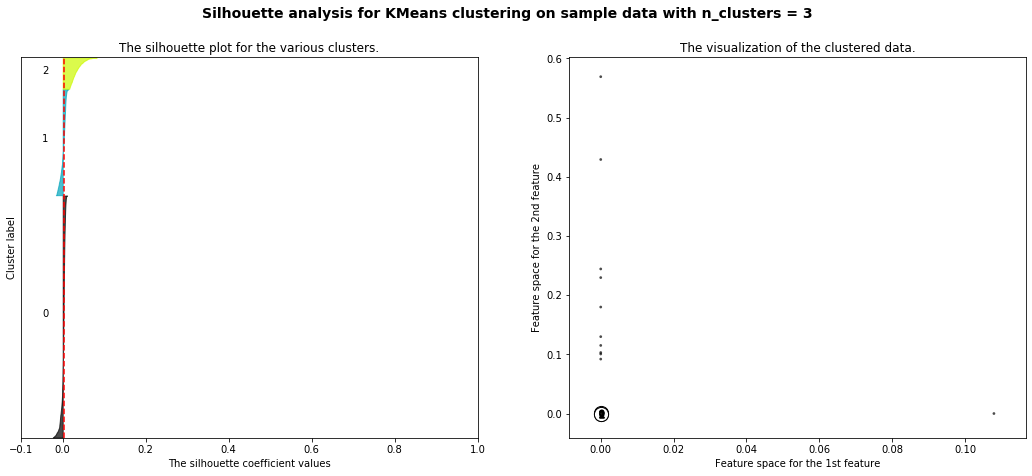

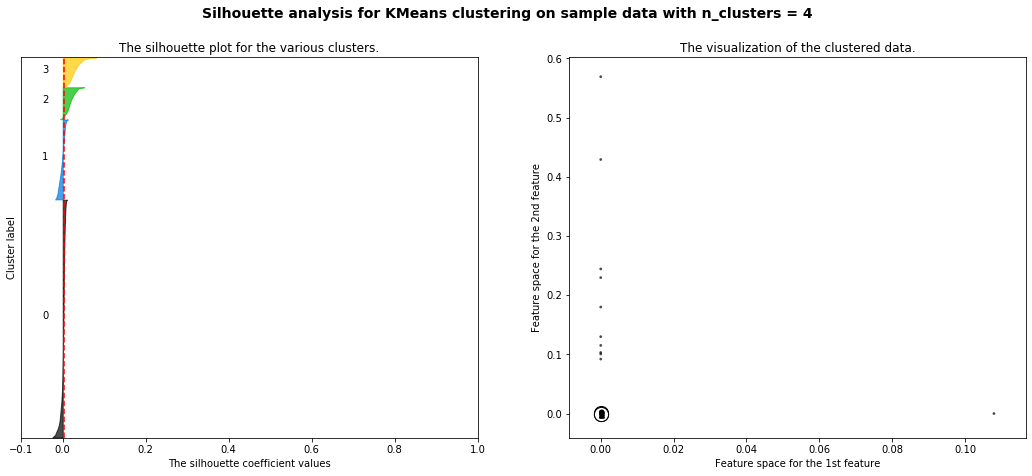

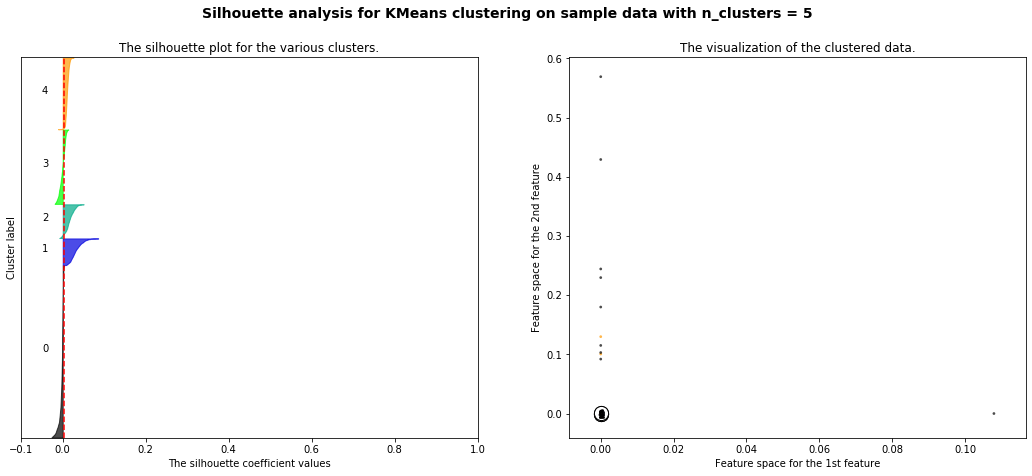

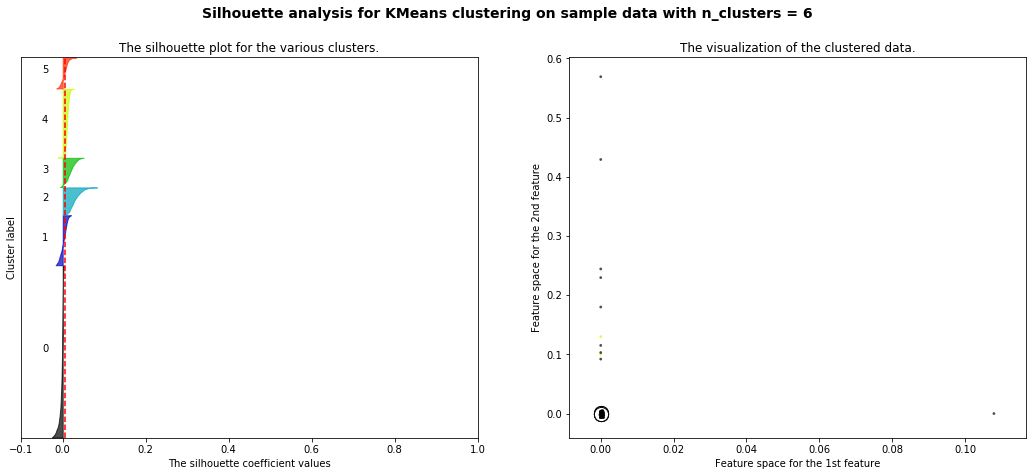

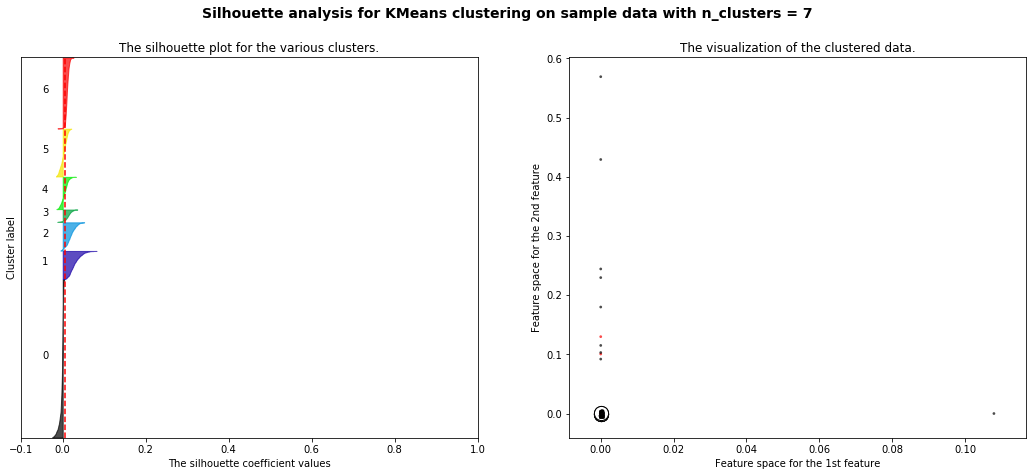

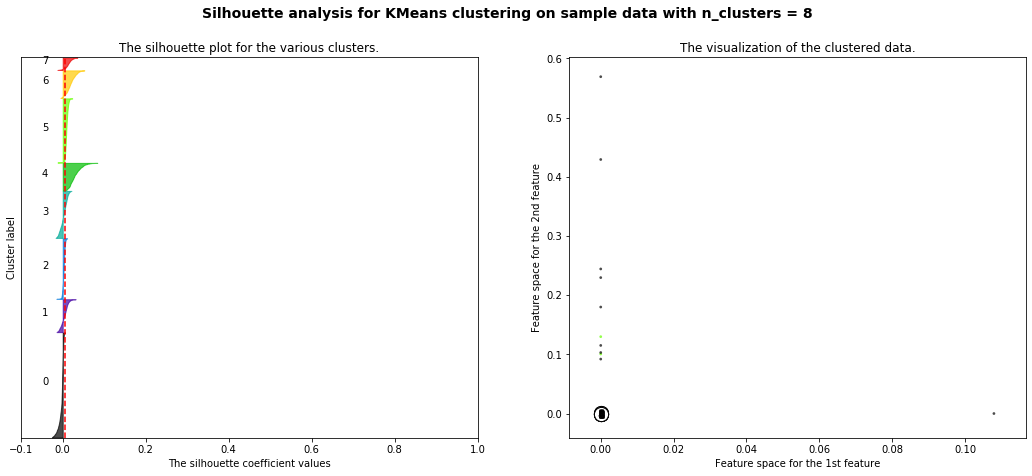

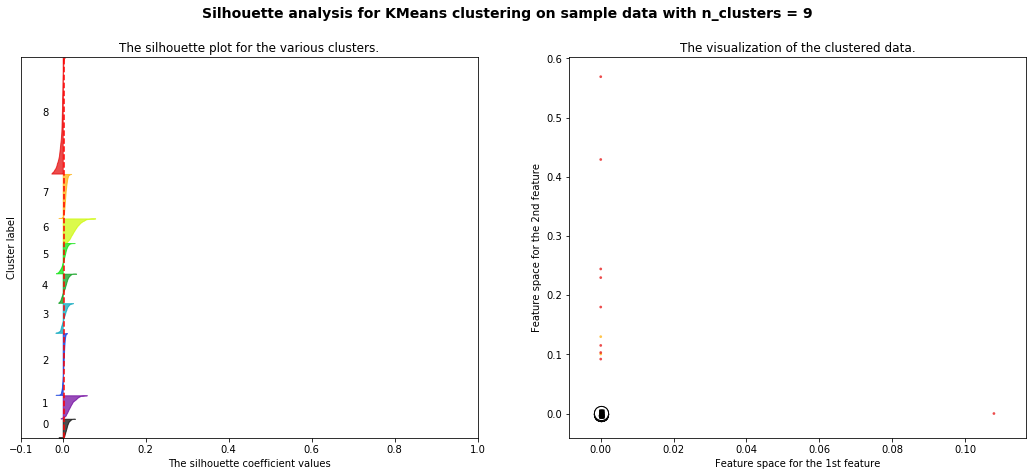

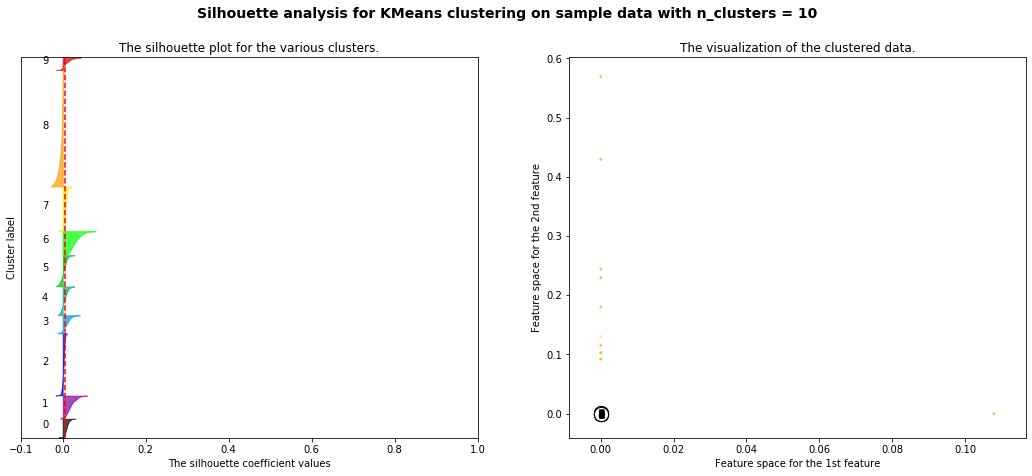

In [0]:
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, X_tf_idf.shape[0] + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_tf_idf)

    silhouette_avg = silhouette_score(X_tf_idf, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X_tf_idf, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):

        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_tf_idf[:, 0].toarray(), X_tf_idf[:, 1].toarray(), marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

KMeans TF-IFD cũng cho kết quả không tốt.

## Coculusion

Bag of Word và TF-IDF cho kết quả phân loại khá tốt khi sử dụng Naive Bayes và Logistic Regression,  Decision Tree và Random Forest cho kết quả không tốt bằng.

Word2Vec biểu diễn tốt với từng từ đơn lẻ nhưng khi biểu diễn 1 đoạn văn có số lượng từ lớn bằng cách lấy trung bình cộng các từ từ cho kết quả không tốt bằng Bag of Word và TF-IDF, tuy vậy kết quả phân loại vẫn đạt trên 80%.

LSTM cho kết quả khá tốt, trên 95% sau 15 epochs.

Clustering với Bag of Word và TF-IDF cho kết quả không tốt với silhouette scores gần với 0 do hầu hết các từ đều xuất hiện ở tất cả các document, rất ít từ chỉ xuất hiện ở một document duy nhât, dẫn đến silhouette scores gần bằng 0 thậm chí âm.
